## Load libraries

In [1]:
import numpy as np
import scipy
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import math
import gsw ## Water equation of state
import matplotlib.cm as cm

## Load data

In [2]:
CTD1 = scipy.io.loadmat('GRISOACDC_DataProject/data_porsild/ctd1_data.mat')
index_min = 2358
index_max = 7595
depth_CTD1 = CTD1['depth']
dens_CTD1  = CTD1['dens']
press_CTD1 = 0.689476*CTD1['pres'] ## psi to dbar
sal_CTD1   = CTD1['sal']
cond_CTD1  = CTD1['cond']
temp_CTD1  = CTD1['temp']
turb_CTD1  = CTD1['turb']
fluor_CTD1 = CTD1['fluor']

Dsolo_withCTD1  = scipy.io.loadmat('GRISOACDC_DataProject/data_porsild/DR_data_withctd1.mat')
depth_withCTD1  = np.copy(Dsolo_withCTD1['depth024092'])[2100:3409]
press_withCTD1  = np.copy(Dsolo_withCTD1['press024092'])[2100:3409]-10.1325
timeD_withCTD1  = np.copy(Dsolo_withCTD1['time024092'])[2100:3409]-10.1325

Tsolo_withCTD1  = scipy.io.loadmat('GRISOACDC_DataProject/data_porsild/Tsolo_data_withctd1.mat')
offset = 269
temp1_withCTD1  = Tsolo_withCTD1['temp102658'][2630+offset:3939+offset]
timeT1_withCTD1 = Tsolo_withCTD1['time102658'][2630+offset:3939+offset]
temp2_withCTD1  = Tsolo_withCTD1['temp102659'][2630:3939]
timeT2_withCTD1 = Tsolo_withCTD1['time102658'][2630:3939]

CTD2 = pd.read_csv("GRISOACDC_DataProject/data_porsild/ctd2_data.txt", sep=",")
CTD2 = CTD2.drop(0) # Drop first row

## Function to bin on pressure values

In [3]:
def press_binning(pressure, field, deltaP = 1.0):
    
    pressure_bins = np.arange(math.floor(np.min(pressure))+0.5*deltaP, np.max(pressure)+deltaP, deltaP)
    binned_field  = np.zeros(pressure_bins.shape)
    num_in_bin    = np.zeros(pressure_bins.shape, dtype = int)
    bin_low       = np.zeros(pressure_bins.shape)
    bin_high      = np.zeros(pressure_bins.shape)
    
    for i in range(len(pressure_bins)):
        bin_low    = math.floor(np.min(pressure)) + i*deltaP
        bin_high   = math.floor(np.min(pressure)) + (i+1)*deltaP
        field_in_bin  = field[np.where((pressure>=bin_low) & (pressure<bin_high))]
        binned_field[i] = np.mean(field_in_bin)
    return pressure_bins, binned_field

## Bin data on pressure values

In [4]:
binned_pressure_1, binned_depth_1  = press_binning(press_CTD1[index_min:index_max], depth_CTD1[index_min:index_max])
binned_pressure_1, binned_sal_1    = press_binning(press_CTD1[index_min:index_max], sal_CTD1[index_min:index_max])
binned_pressure_1, binned_temp_1   = press_binning(press_CTD1[index_min:index_max], temp_CTD1[index_min:index_max])
binned_pressure_1, binned_turb_1   = press_binning(press_CTD1[index_min:index_max], turb_CTD1[index_min:index_max])
binned_pressure_1, binned_dens_1   = press_binning(press_CTD1[index_min:index_max], dens_CTD1[index_min:index_max])
binned_pressure_1, binned_fluor_1  = press_binning(press_CTD1[index_min:index_max], fluor_CTD1[index_min:index_max])

binned_pressure1_withCTD1, binned_temp1_withCTD1 = press_binning(press_withCTD1, temp1_withCTD1)
binned_pressure2_withCTD1, binned_temp2_withCTD1 = press_binning(press_withCTD1, temp2_withCTD1)

binned_pressure_2, binned_depth_2  = press_binning(np.asarray(CTD2['Pressure']), np.asarray(CTD2['Depth']))
binned_pressure_2, binned_sal_2    = press_binning(np.asarray(CTD2['Pressure']), np.asarray(CTD2['Salinity']))
binned_pressure_2, binned_temp_2   = press_binning(np.asarray(CTD2['Pressure']), np.asarray(CTD2['Temperature']))
binned_pressure_2, binned_turb_2   = press_binning(np.asarray(CTD2['Pressure']), np.asarray(CTD2['Turbidity']))
binned_pressure_2, binned_dens_2   = press_binning(np.asarray(CTD2['Pressure']), np.asarray(CTD2['Density']))
binned_pressure_2, binned_DO_2   = press_binning(np.asarray(CTD2['Pressure']), np.asarray(CTD2['Dissolved Oxygen']))
binned_pressure_2, binned_LP_2   = press_binning(np.asarray(CTD2['Pressure']), np.asarray(CTD2['PAR-Irradiance']))
binned_pressure_2, binned_CB_2   = press_binning(np.asarray(CTD2['Pressure']), np.asarray(CTD2['Chloro-blue']))

/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Sanity check

Compare if the equation of state gives the same density profile as the density calculated diagnostically by the CTD cast.

In [5]:
lat = 69.028
lon = -53.131

binned_dens_1_gsw_old = np.zeros(binned_dens_1.shape)
binned_dens_2_gsw_old = np.zeros(binned_dens_2.shape)

binned_abs_sal_1 = np.zeros(binned_sal_1.shape)
binned_abs_sal_2 = np.zeros(binned_sal_2.shape)

for i in range(len(binned_sal_1)):
    binned_abs_sal_1[i] = gsw.conversions.SA_from_SP(binned_sal_1[i], binned_pressure_1[i], lon, lat)
    binned_dens_1_gsw_old[i] = gsw.density.rho_t_exact(binned_abs_sal_1[i], binned_temp_1[i], binned_pressure_1[i])
    
for i in range(len(binned_sal_2)):
    binned_abs_sal_2[i] = gsw.conversions.SA_from_SP(binned_sal_2[i], binned_pressure_2[i], lon, lat)
    binned_dens_2_gsw_old[i] = gsw.density.rho_t_exact(binned_abs_sal_2[i], binned_temp_2[i], binned_pressure_2[i])

binned_dens_1_gsw = np.zeros(binned_dens_1.shape)
binned_dens_2_gsw = np.zeros(binned_dens_2.shape)

L2norm_err_1 = np.zeros((1000))
for j in range(1000):
    pres_corr_1 = j
    for i in range(len(binned_sal_1)):
        binned_dens_1_gsw[i] = gsw.density.rho_t_exact(binned_abs_sal_1[i], binned_temp_1[i], binned_pressure_1[i]+pres_corr_1)
    L2norm_err_1[j] = np.linalg.norm(binned_dens_1-binned_dens_1_gsw)

L2norm_err_2 = np.zeros((1000))
for j in range(1000):
    pres_corr_2 = j
    for i in range(len(binned_sal_2)):
        binned_dens_2_gsw[i] = gsw.density.rho_t_exact(binned_abs_sal_2[i], binned_temp_2[i], binned_pressure_2[i]+pres_corr_2)
    L2norm_err_2[j] = np.linalg.norm(binned_dens_2-binned_dens_2_gsw)
    
pres_corr_1 = np.argmin(L2norm_err_2) ### Turns out to be 0
pres_corr_2 = np.argmin(L2norm_err_2) ### Turns out to be 0

for i in range(len(binned_sal_1)):
    binned_dens_1_gsw[i] = gsw.density.rho_t_exact(binned_abs_sal_1[i], binned_temp_1[i], binned_pressure_1[i]+pres_corr_1)
    
for i in range(len(binned_sal_2)):
    binned_dens_2_gsw[i] = gsw.density.rho_t_exact(binned_abs_sal_2[i], binned_temp_2[i], binned_pressure_2[i]+pres_corr_2)

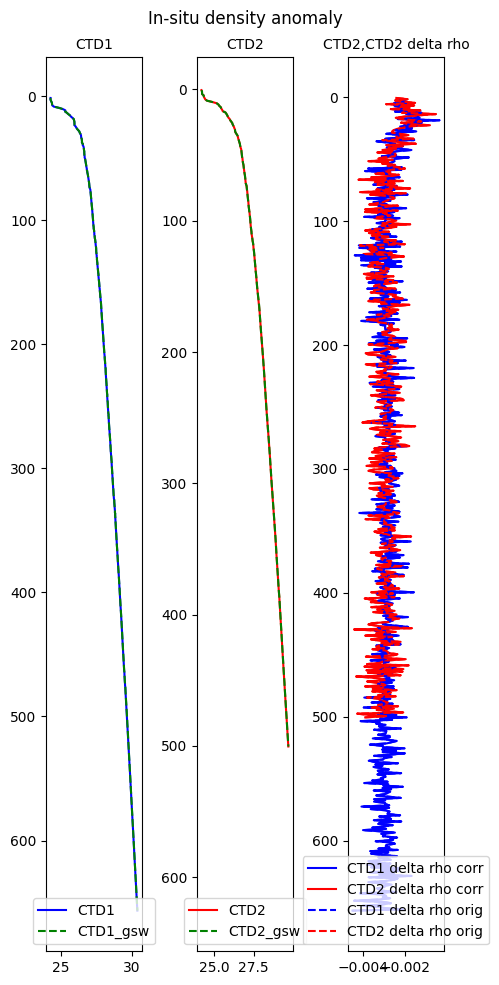

In [6]:
plt.rcParams["figure.figsize"] = (5,10)
fig, ax = plt.subplots(1,3)

ax[0].plot(binned_dens_1-1000, binned_pressure_1, 'b-', label = 'CTD1')
# ax[0].plot(binned_dens_1_gsw_old, binned_pressure_1, 'orange', label = 'CTD1_gsw_orig')
ax[0].plot(binned_dens_1_gsw-1000, binned_pressure_1, 'g--', label = 'CTD1_gsw')
ax[0].set_title('CTD1', fontsize=10)
ax[0].legend(loc = 'lower center')
ax[0].invert_yaxis()

ax[1].plot(binned_dens_2-1000, binned_pressure_2, 'r-', label = 'CTD2')
# ax[1].plot(binned_dens_2_gsw_old, binned_pressure_2, 'orange', label = 'CTD2_gsw_orig')
ax[1].plot(binned_dens_2_gsw-1000, binned_pressure_2, 'g--', label = 'CTD2_gsw')
ax[1].set_ylim(top=binned_pressure_1[-1])
ax[1].set_title('CTD2', fontsize=10)
ax[1].legend(loc = 'lower center')
ax[1].invert_yaxis()

ax[2].plot(binned_dens_1-binned_dens_1_gsw, binned_pressure_1, 'b-', label = 'CTD1 delta rho corr')
ax[2].plot(binned_dens_2-binned_dens_2_gsw, binned_pressure_2, 'r-', label = 'CTD2 delta rho corr')
ax[2].plot(binned_dens_1-binned_dens_1_gsw_old, binned_pressure_1, 'b--', label = 'CTD1 delta rho orig')
ax[2].plot(binned_dens_2-binned_dens_2_gsw_old, binned_pressure_2, 'r--', label = 'CTD2 delta rho orig')
ax[2].set_title('CTD2,CTD2 delta rho', fontsize=10)
ax[2].legend(loc = 'lower center')
ax[2].invert_yaxis()

fig.suptitle('In-situ density anomaly')
plt.tight_layout()

## Plot binned data fields

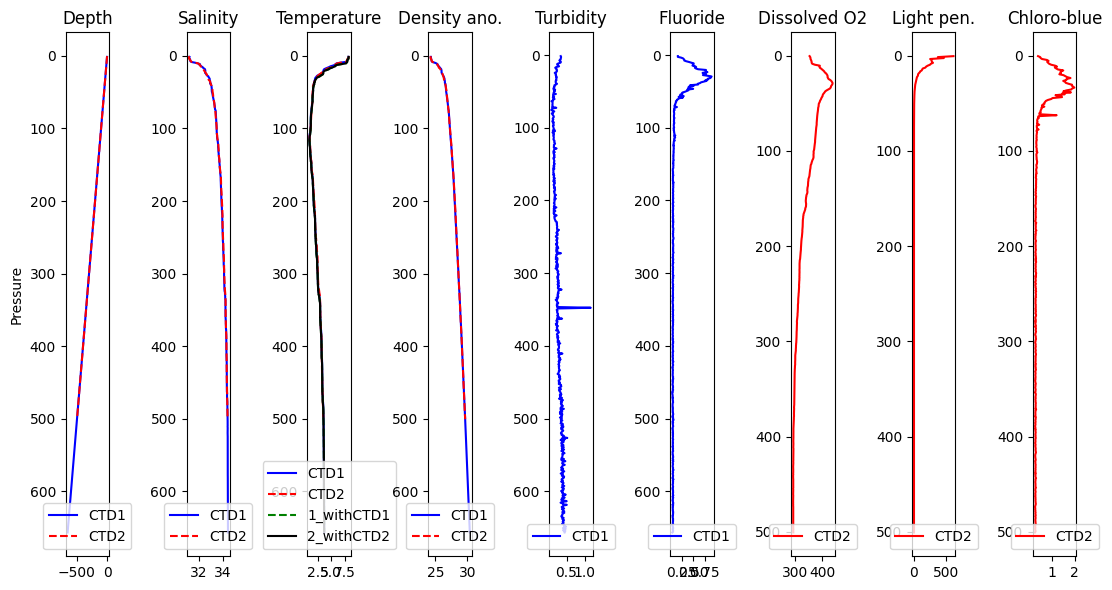

In [7]:
plt.rcParams["figure.figsize"] = (11,6)

fig, ax = plt.subplots(1,9)

ax[0].plot(binned_depth_1, binned_pressure_1, 'b-', label = 'CTD1')
ax[0].plot(-binned_depth_2, binned_pressure_2, 'r--', label = 'CTD2')
ax[0].set_title('Depth')
ax[0].set_ylabel('Pressure')
ax[0].invert_yaxis()
ax[0].legend(loc = 'lower center')

ax[1].plot(binned_sal_1, binned_pressure_1, 'b-', label = 'CTD1')
ax[1].plot(binned_sal_2, binned_pressure_2, 'r--', label = 'CTD2')
ax[1].set_title('Salinity')
ax[1].invert_yaxis()
ax[1].legend(loc = 'lower center')

ax[2].plot(binned_temp_1, binned_pressure_1, 'b-', label = 'CTD1')
ax[2].plot(binned_temp_2, binned_pressure_2, 'r--', label = 'CTD2')
ax[2].plot(binned_temp1_withCTD1, binned_pressure1_withCTD1, 'g--', label = '1_withCTD1')
ax[2].plot(binned_temp2_withCTD1, binned_pressure2_withCTD1, 'black', label = '2_withCTD2')
ax[2].set_title('Temperature')
ax[2].invert_yaxis()
ax[2].legend(loc = 'lower center')

ax[3].plot(binned_dens_1-1000, binned_pressure_1, 'b-', label = 'CTD1')
ax[3].plot(binned_dens_2-1000, binned_pressure_2, 'r--', label = 'CTD2')
ax[3].set_title('Density ano.')
ax[3].invert_yaxis()
ax[3].legend(loc = 'lower center')

ax[4].plot(binned_turb_1, binned_pressure_1, 'b-', label = 'CTD1')
# ax[4].plot(binned_turb_2, binned_pressure_2, 'r-', label = 'CTD2')
ax[4].set_title('Turbidity')
ax[4].invert_yaxis()
ax[4].legend(loc = 'lower center')

ax[5].plot(binned_fluor_1, binned_pressure_1, 'b-', label = 'CTD1')
ax[5].set_title('Fluoride')
ax[5].invert_yaxis()
ax[5].legend(loc = 'lower center')

ax[6].plot(binned_DO_2, binned_pressure_2, 'r-', label = 'CTD2')
ax[6].set_title('Dissolved O2')
ax[6].invert_yaxis()
ax[6].legend(loc = 'lower center')

ax[7].plot(binned_LP_2, binned_pressure_2, 'r-', label = 'CTD2')
ax[7].set_title('Light pen.')
ax[7].invert_yaxis()
ax[7].legend(loc = 'lower center')

ax[8].plot(binned_CB_2, binned_pressure_2, 'r-', label = 'CTD2')
ax[8].set_title('Chloro-blue')
ax[8].invert_yaxis()
ax[8].legend(loc = 'lower center')

plt.tight_layout()

## Turbidity sensor of CTD2 seems to be malfunctioning

You can remove the peak at the top and the profile is still spiky, so I think the sensor has gone bad.

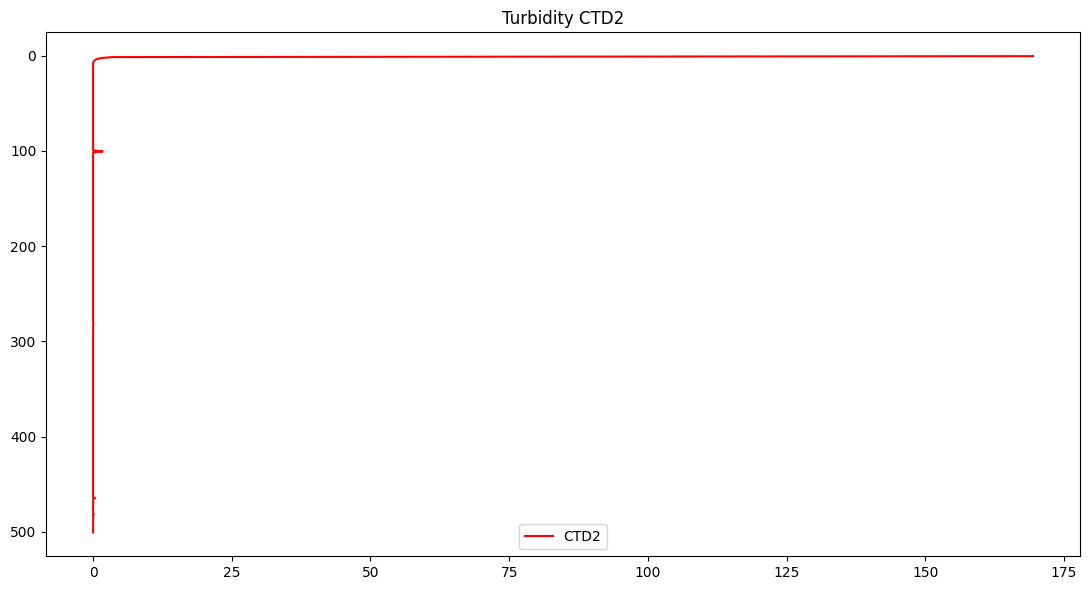

In [8]:
plt.rcParams["figure.figsize"] = (11,6)

fig, ax = plt.subplots()

# ax.plot(binned_turb_1, binned_pressure_1, 'b-', label = 'CTD1')
ax.plot(binned_turb_2, binned_pressure_2, 'r-', label = 'CTD2')
ax.set_title('Turbidity CTD2')
ax.invert_yaxis()
ax.legend(loc = 'lower center')

plt.tight_layout()

## Calculate T-S plots

To be extra careful, we plot conservative temperature vs absolute salinity, thus removing the dependence on pressure completely. You can see the density contours in the background.

In [9]:
binned_pot_temp_1 = np.zeros(binned_temp_1.shape)
binned_con_temp_1 = np.zeros(binned_temp_1.shape)

binned_pot_temp_2 = np.zeros(binned_temp_2.shape)
binned_con_temp_2 = np.zeros(binned_temp_2.shape)

binned_pot_dens_1 = np.zeros(binned_dens_1.shape)
binned_pot_dens_2 = np.zeros(binned_dens_2.shape)

for i in range(len(binned_pot_temp_1)):
    binned_pot_temp_1[i] = gsw.conversions.pt0_from_t(binned_sal_1[i], binned_temp_1[i], binned_pressure_1[i])
    binned_con_temp_1[i] = gsw.conversions.CT_from_pt(binned_sal_1[i], binned_pot_temp_1[i])
    binned_pot_dens_1[i] = gsw.density.sigma0(binned_sal_1[i], binned_con_temp_1[i])
    
for i in range(len(binned_pot_temp_2)):
    binned_pot_temp_2[i] = gsw.conversions.pt0_from_t(binned_sal_2[i], binned_temp_2[i], binned_pressure_2[i])
    binned_con_temp_2[i] = gsw.conversions.CT_from_pt(binned_sal_2[i], binned_pot_temp_2[i])
    binned_pot_dens_2[i] = gsw.density.sigma0(binned_sal_2[i], binned_con_temp_2[i])

sal_grid = np.arange(31,34.51,0.01)
con_temp_grid = np.arange(-2.0,9.01,0.01)

density_contours = np.zeros((sal_grid.shape[0],con_temp_grid.shape[0]))

sal_2D_grid, con_temp_2D_grid = np.meshgrid(sal_grid, con_temp_grid, indexing='ij')

for i in range(sal_grid.shape[0]):
    for j in range(con_temp_grid.shape[0]):
        density_contours[i,j] = gsw.density.sigma0(sal_grid[i], con_temp_grid[j])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Depth')

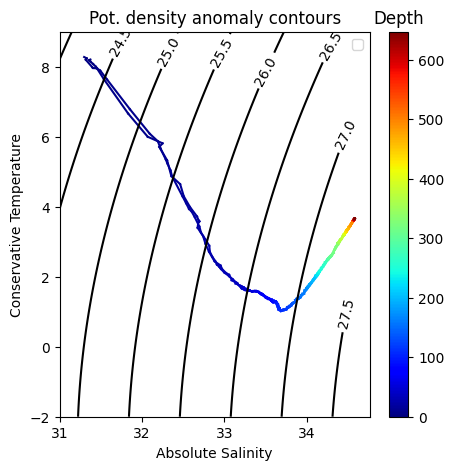

In [10]:
### https://stackoverflow.com/questions/36505587/color-line-by-third-variable-python

plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()

col = cm.jet((np.max(binned_depth_1)-binned_depth_1)/(np.max(binned_depth_1)-np.min(binned_depth_1)))

for i in np.arange(len(binned_abs_sal_1)-1):
    ax.plot([binned_abs_sal_1[i],binned_abs_sal_1[i+1]], [binned_con_temp_1[i],binned_con_temp_1[i+1]], c=col[i])

im = ax.scatter(binned_abs_sal_1, binned_con_temp_1, c=binned_depth_1-np.min(binned_depth_1), s=0, cmap=cm.jet)
    
for i in np.arange(len(binned_abs_sal_2)-1):
    ax.plot([binned_abs_sal_2[i],binned_abs_sal_2[i+1]], [binned_con_temp_2[i],binned_con_temp_2[i+1]], c=col[i])

CS = ax.contour(sal_2D_grid, con_temp_2D_grid, density_contours, colors='k')
ax.clabel(CS, inline=True, fontsize=10)
ax.set_xlabel("Absolute Salinity")
ax.set_ylabel("Conservative Temperature")
ax.legend()
ax.set_title("Pot. density anomaly contours")
clb = fig.colorbar(im)
clb.ax.set_title('Depth')